In [250]:
import os
import numpy as np
import pandas as pd
import torch
import math
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [251]:
# reading a single csv into a pytorch tensor
df = pd.read_csv("motionSense/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_10.csv")
df.head()
features = list(df.columns)[1:]
print("features: ",features)
array = df.to_numpy()
print("array shape: ", array.shape)
clipped = array[:,1:]
print("clipped shape: ",clipped.shape)
p = torch.tensor(clipped)
print("tensor shape: ", p.shape)

features:  ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
array shape:  (2678, 13)
clipped shape:  (2678, 12)
tensor shape:  torch.Size([2678, 12])


In [252]:
import numpy as np
import pandas as pd
##_____________________________

def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("motionSense/data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss
##____________

def create_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'motionSense/A_DeviceMotion_data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 6 # dws, ups, wlk, jog, sit, std
num_gen_labels = 1 # 0/1(female/male)
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    
## Calling 'create_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = create_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Series:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Series: (1082373, 19)
--> Shape of Test Time-Series: (331419, 19)


In [253]:
x = torch.tensor(train_ts[:,:12]).float()
print(x.shape)
y = torch.tensor(train_ts[:,12:18]).float()
print(y.shape)
print(y[0])


torch.Size([1082373, 12])
torch.Size([1082373, 6])
tensor([1., 0., 0., 0., 0., 0.])


In [254]:
classes = []
total_samples = 0
for i in range(6):
    new_class = train_ts[np.where(train_ts[:,12 + i])]
    print("class ", i, " shape: ", new_class.shape)
    classes.append(new_class)
    total_samples += len(new_class)
print("num classes: ", np.shape(classes))
print("num samples: ", total_samples)

class  0  shape:  (110281, 19)
class  1  shape:  (129276, 19)
class  2  shape:  (279016, 19)
class  3  shape:  (104327, 19)
class  4  shape:  (234657, 19)
class  5  shape:  (224816, 19)
num classes:  (6,)
num samples:  1082373


/Users/matthew/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [255]:
data = []
labels = []
for i in range(6):
    data.append(classes[i][:,:12])
    labels.append(classes[i][:,13:])
    print(data[i].shape)

(110281, 12)
(129276, 12)
(279016, 12)
(104327, 12)
(234657, 12)
(224816, 12)


In [256]:
num_frames = 5
input_sz = num_frames*12
new_data = []
for i in range(6):
    print("class ", i)
    print(data[i].shape)
    data[i] = data[i][:data[i].shape[0] - data[i].shape[0] % num_frames,:]
    new_data.append(data[i].reshape(-1,input_sz).astype(float))
    print(new_data[i].shape)

class  0
(110281, 12)
(22056, 60)
class  1
(129276, 12)
(25855, 60)
class  2
(279016, 12)
(55803, 60)
class  3
(104327, 12)
(20865, 60)
class  4
(234657, 12)
(46931, 60)
class  5
(224816, 12)
(44963, 60)


In [257]:
for i in range(6):
    print(len(new_data[i]))
    new_data[i] = np.array([np.append(new_data[i][j],i) for j in range(len(new_data[i]))])
    print(new_data[i].shape)

22056
(22056, 61)
25855
(25855, 61)
55803
(55803, 61)
20865
(20865, 61)
46931
(46931, 61)
44963
(44963, 61)


In [258]:
arr = np.array(np.concatenate(new_data, axis=0))
print(arr.shape)
x = arr[:,:-1]
y = arr[:,-1:]
print(x.shape)
print(y.shape)

(216473, 61)
(216473, 60)
(216473, 1)


In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [260]:
# 5 step input, 12 values. 6 class labels
output_sz = 1
net = Net(input_size=input_sz, output_size=output_sz)
print(net)

Net(
  (fc1): Linear(in_features=60, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [261]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
losses = []

Using device: cpu


In [262]:
y_target = torch.tensor(y).float()
x = torch.tensor(x).float()
y_target = y_target.to(device)

In [263]:
import matplotlib.pyplot as plt
import torch
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import torch.nn.functional as F

def plot(xs, ys, xlim=(-3, 3), ylim=(-1, 12)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')
  
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

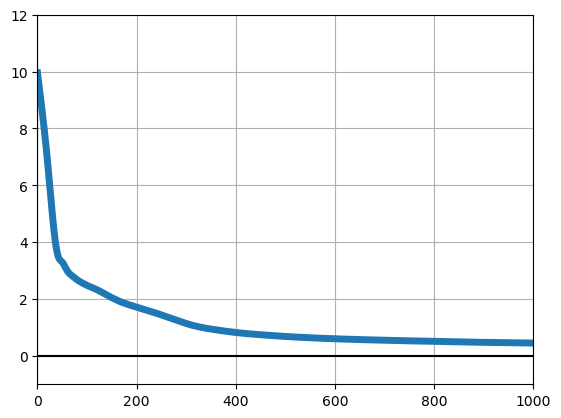

In [264]:
for _ in range(1000):
    x = x.to(device)
    y = net(x)
    loss = loss_fn(y, y_target)
    losses.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plot(range(1000), losses, xlim=(0, 1000))

In [265]:
for i in range(len(losses)):
    print(losses[i])

9.952742
9.8151655
9.676857
9.538144
9.397652
9.2550955
9.111981
8.967994
8.822208
8.6749325
8.526031
8.375148
8.222787
8.068425
7.9104457
7.749
7.583826
7.4146457
7.241646
7.064436
6.8829827
6.697273
6.5079117
6.3160877
6.122124
5.926405
5.7305794
5.5359325
5.3435984
5.154582
4.970249
4.7915006
4.6193776
4.454937
4.29923
4.1530714
4.017784
3.8948681
3.7852037
3.6891081
3.6068864
3.5384421
3.483227
3.4400208
3.4070947
3.382243
3.3629107
3.3466163
3.3309457
3.3139987
3.294438
3.2714922
3.2450223
3.2153947
3.1833656
3.1499038
3.1160212
3.0826664
3.0506115
3.0203543
2.99227
2.9664996
2.9431214
2.9219952
2.9028845
2.885458
2.8693607
2.8542347
2.8397665
2.8256896
2.8117867
2.7978833
2.7839026
2.769853
2.7557602
2.741689
2.7277155
2.7139094
2.700334
2.6870966
2.6742892
2.6619372
2.650056
2.6386414
2.6276586
2.6170619
2.6067922
2.5967925
2.587003
2.5773728
2.567858
2.5584357
2.549093
2.5398302
2.5306637
2.5216038
2.5126703
2.5038757
2.495233
2.4867377
2.4784071
2.4702523
2.462266
2.4544103
2.